In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/home/user/my-proj/pythorch_test/venv/lib/python3.10/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/user/my-proj/pythorch_test/venv/lib/python3.10/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/user/my-proj/pythorch_test/venv/lib/python3.10/site-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/user/my-proj/pythorch_test/venv/lib/python3.10/site-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [4]:
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [5]:
X_train = X_train.float()
X_test = X_test.float()

In [6]:
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [7]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

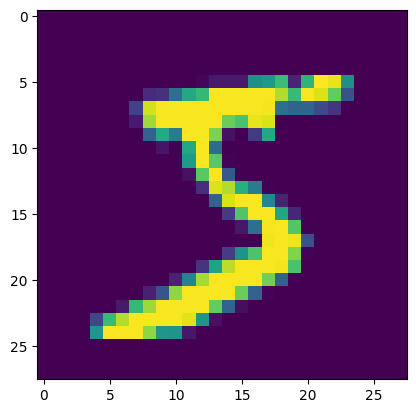

tensor(5)


In [8]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [9]:
X_train = X_train.reshape((-1, 1, 28, 28))
X_test = X_test.reshape((-1, 1, 28, 28))

In [70]:
class MNISTNet(torch.nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.activation = torch.nn.ReLU()

        self.input = torch.nn.Conv2d(1, 1, 20)
        self.inner = torch.nn.Conv2d(1, 1, 10)
        self.flat = torch.nn.Flatten()
        self.output = torch.nn.Linear(442, 10) 
    
    def forward(self, x):
        x0 = x.clone()
        x1 = self.input(x0)
        x1 = self.activation(x1)
        x2 = self.inner(x0)
        x2 = self.activation(x2)
        x1 = self.flat(x1)
        x2 = self.flat(x2)
        x = torch.cat((x1, x2), dim=1)
        x = self.output(x)
        return x
    
mnist_net = MNISTNet().cuda()

In [75]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-4)

In [76]:
from ipywidgets import IntProgress
from IPython.display import display
import time

batch_size = 100

torch.backends.cudnn.deterministic = True
test_accuracy_history = []
test_loss_history = []
train_loss_history = []

X_test = X_test.cuda()
y_test = y_test.cuda()

n_epochs = 100

f = IntProgress(min=0, max=n_epochs)
display(f)

for epoch in range(n_epochs):
    order = np.random.permutation(len(X_train))

    train_loss_history.append(0)
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].cuda()
        y_batch = y_train[batch_indexes].cuda()
        
        preds = mnist_net.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        train_loss_history[-1] += float(loss_value)

        optimizer.step()

    test_preds = mnist_net.forward(X_test)
    test_loss_history.append(float(loss(test_preds, y_test).cpu()))
    train_loss_history[-1] /= len(X_train) / batch_size - 1

    accuracy = float((test_preds.argmax(dim=1) == y_test).float().mean().cpu())
    test_accuracy_history.append(accuracy)

    f.value += 1
    time.sleep(.1)

IntProgress(value=0)

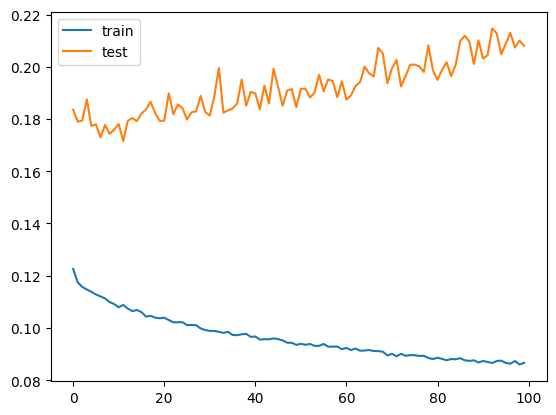

In [77]:
plt.plot(train_loss_history, label="train")
plt.plot(test_loss_history, label="test")
plt.legend()

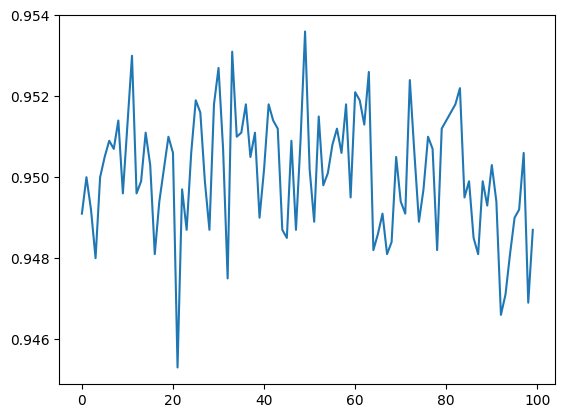

In [78]:
plt.plot(test_accuracy_history)

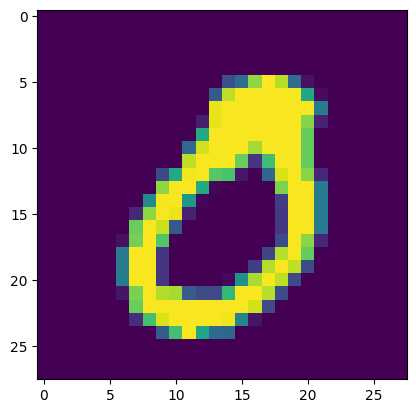

tensor(0)
tensor([0], device='cuda:0')


In [81]:
n = 75
plt.imshow(X_train[n, 0, :, :])
plt.show()
print(y_train[n])
print(mnist_net.forward(X_train[n, 0, :, :].view((-1, 28, 28)).cuda()).argmax(dim=1))